In [23]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas
from dnafiber.analysis.ratios import (
    create_swarm_plot,
    create_violin_plot,
    load_experiment,
    load_experiment_predictions,
    graders_statistical_test,
    compare_pairs,

    create_boxen_plot
)
from dnafiber.deployment import ENSEMBLE, run_one_file
from dnafiber.inference import _get_model

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/")
output = Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/")
output.mkdir(exist_ok=True, parents=True)
all_files = list(root.rglob("*.dv"))

# all_files = [Path("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp8/HeLa_200HU_02HG/HeLa_200HU_02HG_01_R3D.dv")]
for file in tqdm(all_files):
    path_from_input = file.relative_to(root)
    output_file = output / path_from_input.with_suffix(".csv")
    if output_file.exists():
        continue  # Skip if the output file already exists
    predictions = run_one_file(
        file,
        model=ENSEMBLE,
        pixel_size=0.0677249823915,
        reverse_channels=False,
        use_tta=False,
        use_correction=True,
        prediction_threshold=1 / 5,
        verbose=False,
    ) 
    df = predictions.to_df(pixel_size=0.0677249823915, filter_invalid=False)
    df["image_name"] = path_from_input.stem
    output_file.parent.mkdir(exist_ok=True, parents=True)
    df.to_csv(output_file, index=False)


100%|██████████| 1676/1676 [00:00<00:00, 23306.17it/s]


In [25]:
ai_color = "#8caaee"
human_color = "#ea999c"
palette = [human_color, ai_color]


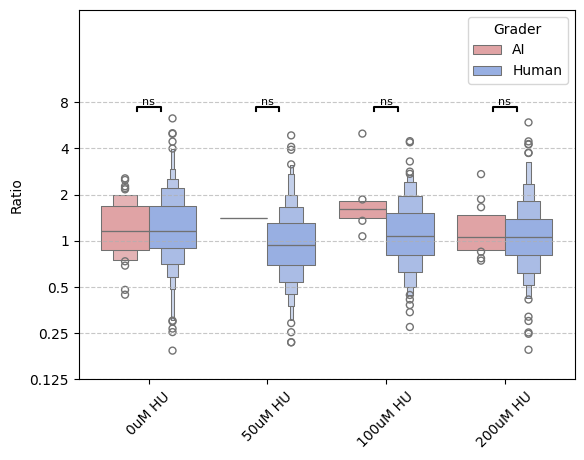

In [26]:
df1 = load_experiment_predictions("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp1/293_100uM_HU/")
df2 = load_experiment_predictions("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp1/293_200uM_HU/")
df3 = load_experiment_predictions("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp1/293-0-HU/")
df4 = load_experiment_predictions("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp1/293-50-HU/")
gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp1/2017_04_05_slidemeasurements.xlsx")
df1["Type"] = "100uM HU"
df2["Type"] = "200uM HU"
df3["Type"] = "0uM HU"
df4["Type"] = "50uM HU"
# df4 = load_experiment_predictions("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp1/293_50_HU/")


gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp1/2017_04_05_slidemeasurements.xlsx", header=2, sheet_name="totals")
gt1 =  pd.DataFrame({"Ratio": gt["2 div 1"], "Type": "0uM HU", "Grader": "Human"})
gt2 =  pd.DataFrame({"Ratio": gt["2 div 1.1"], "Type": "50uM HU", "Grader": "Human"})
gt3 =  pd.DataFrame({"Ratio": gt["2 div 1.2"], "Type": "100uM HU", "Grader": "Human"})
gt4 =  pd.DataFrame({"Ratio": gt["2 div 1.3"], "Type": "200uM HU", "Grader": "Human"})

gt_combined = pd.concat([gt1, gt2, gt3, gt4], ignore_index=True)
gt_combined

df = pd.concat([df3, df4, df1, df2], ignore_index=True)
df = df[df['Fiber type'] == 'double']
df = pd.concat([df3, df4, df1, df2, gt_combined], ignore_index=True)
types = df.Type.unique()
pairs = [(types[i], types[j], i+j) for i in range(len(types)) for j in range(i + 1, len(types))]

create_boxen_plot(df, palette)
graders_statistical_test(df, 7)


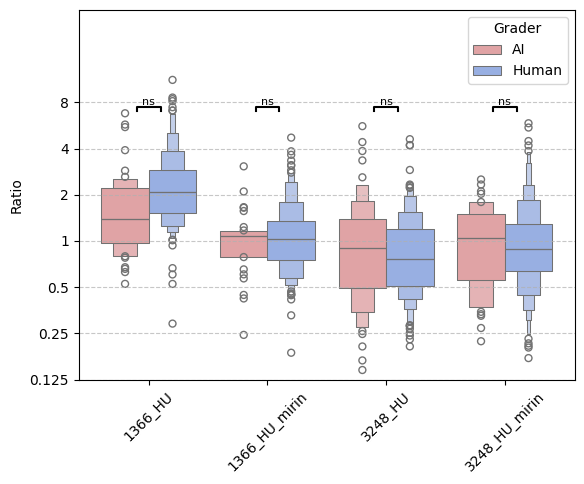

In [38]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp2/").iterdir():    
    df  = load_experiment_predictions(dir)
    df["Type"] = dir.name
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']
gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp2/2017_04_21_fibremeasurements.xlsx")

# df4 = load_experiment_predictions("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp1/293_50_HU/")

gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp2/2017_04_21_fibremeasurements.xlsx", header=2, sheet_name="Sheet2")
gt1 =  pd.DataFrame({"Ratio": gt["2 div 1"], "Type": "1366_HU", "Grader": "Human"})
gt2 =  pd.DataFrame({"Ratio": gt["2 div 1.1"], "Type": "1366_HU_mirin", "Grader": "Human"})
gt3 =  pd.DataFrame({"Ratio": gt["2 div 1.2"], "Type": "3248_HU", "Grader": "Human"})
gt4 =  pd.DataFrame({"Ratio": gt["2 div 1.3"], "Type": "3248_HU_mirin", "Grader": "Human"})


df = pd.concat( [df, gt1, gt2, gt3, gt4], ignore_index=True)

df.replace({"Type": {"3284_HU_mirin": "3248_HU_mirin"}}, inplace=True)
order = ["1366_HU", "1366_HU_mirin", "3248_HU", "3248_HU_mirin"]
df["Type"] = pd.Categorical(df["Type"], categories=order, ordered=True)

create_boxen_plot(df, palette)
graders_statistical_test(df, 7)


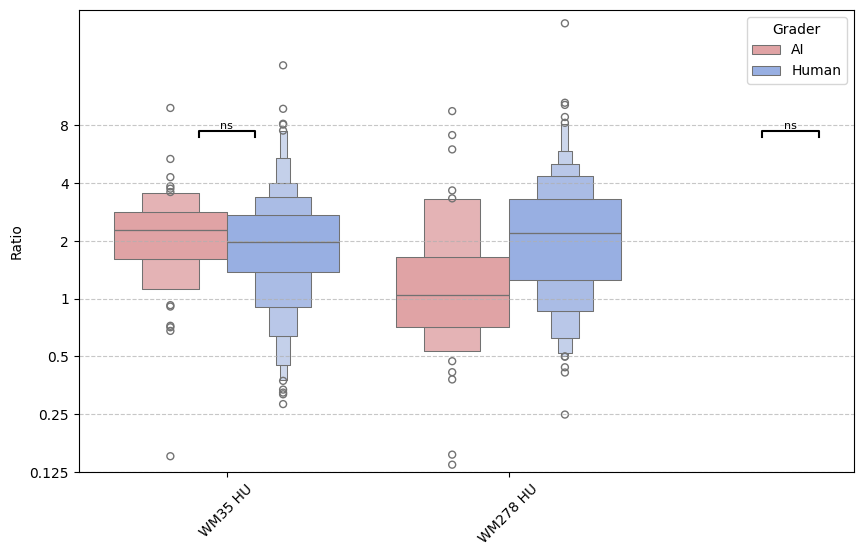

In [39]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp3/").iterdir():    
    df  = load_experiment_predictions(dir)
    df["Type"] = dir.name
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']



gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp3/2017_04_25_fibremeasurements.xlsx", header=2, sheet_name="totals")
gt1 =  pd.DataFrame({"Ratio": gt["2 div 1"], "Type": "WM35 HU", "Grader": "Human"})
gt2 =  pd.DataFrame({"Ratio": gt["2 div 1.1"], "Type": "WM278 HU", "Grader": "Human"})

df = pd.concat([df, gt1, gt2], ignore_index=True)

df.replace({"Type": {"WM35_HU": "WM35 HU", "WM278_HU": "WM278 HU"}}, inplace=True)
order = ["WM35 HU", "WM278 HU"]
df["Type"] = pd.Categorical(df["Type"], categories=order, ordered=True)

plt.figure(figsize=(10, 6))
# create_violin_plot(df, palette)
create_boxen_plot(df, palette)
graders_statistical_test(df, 7)


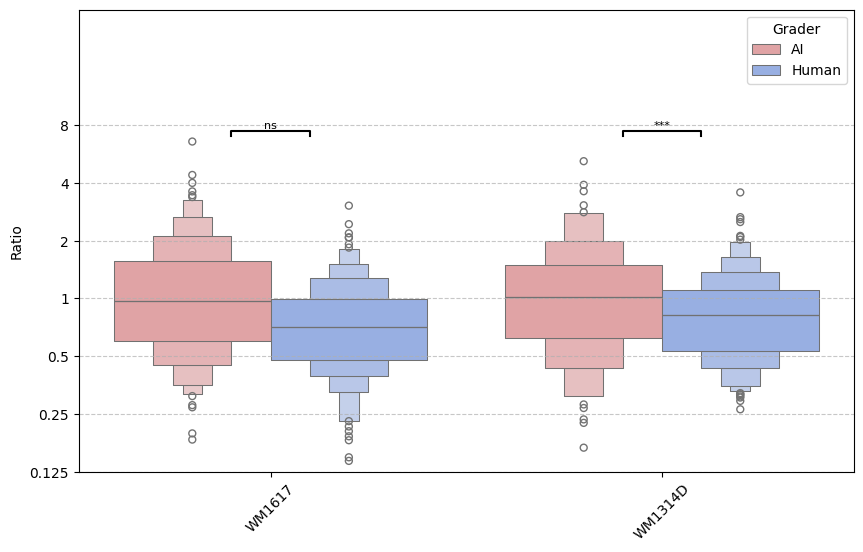

In [40]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp4/").iterdir():    
    df  = load_experiment_predictions(dir)
    df["Type"] = dir.name
    dfs.append(df)



gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp4/2017_04_30_melanomacells3.xlsx", header=2, sheet_name="calculations")
gt1 =  pd.DataFrame({"Ratio": gt["2 over 1"], "Type": "WM1314D", "Grader": "Human"})
gt2 =  pd.DataFrame({"Ratio": gt["2 over 1.1"], "Type": "WM1617", "Grader": "Human"})

df = pd.concat(dfs + [gt1, gt2], ignore_index=True)

df.replace({"Type": {"WM1341D_HU": "WM1314D", "WM1617_HU": "WM1617"}}, inplace=True)
order = ["WM1314D", "WM1617"]
# df["Type"] = pd.Categorical(df["Type"], categories=order, ordered=True)

plt.figure(figsize=(10, 6))
create_boxen_plot(df, palette)
# create_swarm_plot(df, palette)
graders_statistical_test(df, 7)



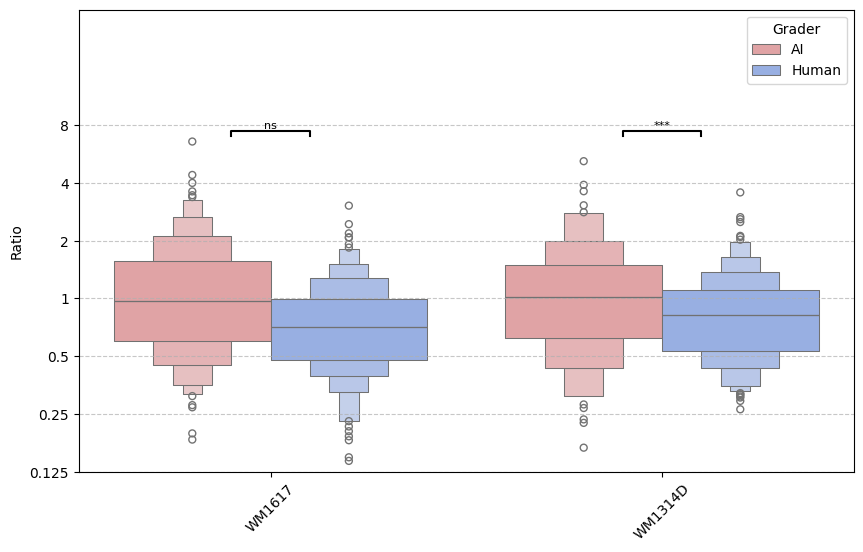

In [41]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp4/").iterdir():    
    df  = load_experiment_predictions(dir)
    df["Type"] = dir.name
    dfs.append(df)



gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp4/2017_04_30_melanomacells3.xlsx", header=2, sheet_name="calculations")
gt1 =  pd.DataFrame({"Ratio": gt["2 over 1"], "Type": "WM1314D", "Grader": "Human"})
gt2 =  pd.DataFrame({"Ratio": gt["2 over 1.1"], "Type": "WM1617", "Grader": "Human"})

df = pd.concat(dfs + [gt1, gt2], ignore_index=True)

df.replace({"Type": {"WM1341D_HU": "WM1314D", "WM1617_HU": "WM1617"}}, inplace=True)
order = ["WM1314D", "WM1617"]
# df["Type"] = pd.Categorical(df["Type"], categories=order, ordered=True)

plt.figure(figsize=(10, 6))
create_boxen_plot(df, palette)
# create_swarm_plot(df, palette)
graders_statistical_test(df, 7)



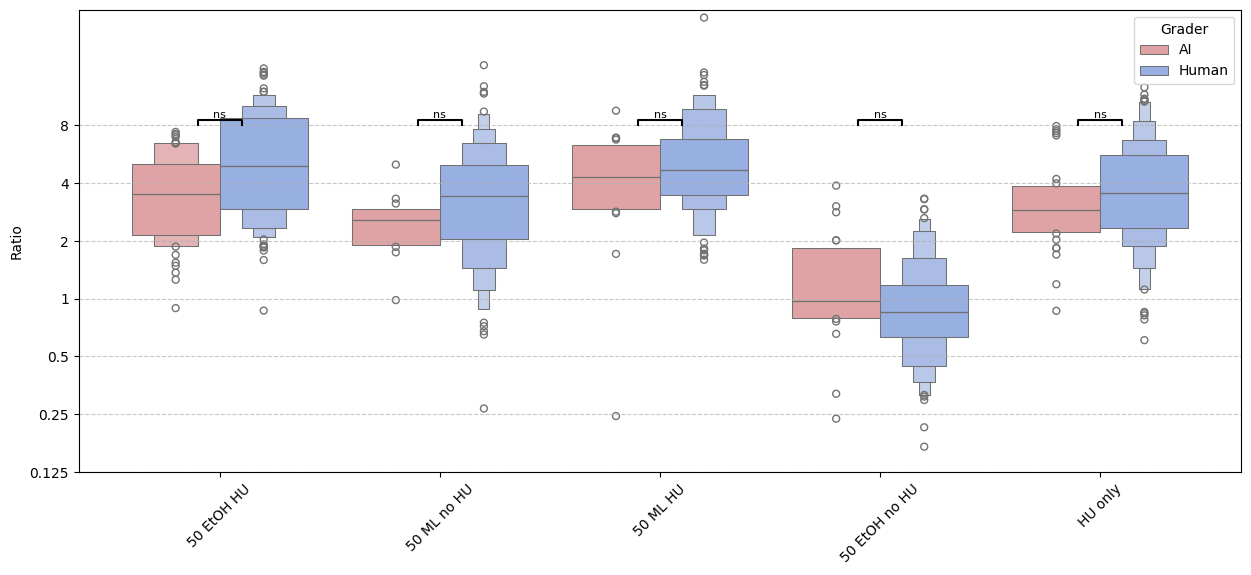

In [31]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp6/").iterdir():    
    df  = load_experiment_predictions(dir)
    name = " ".join(dir.name.split("_")[1:]) # Extract the type from the directory name

    name = " ".join(name.split(" ")[:-1])  # Extract the type from the directory name
    df["Type"] = name
    df["Ratio"] = df["Ratio"]  # Invert the ratio to match the human grading

    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']



gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp6/20170824_100MLfibres.xlsx", header=6, sheet_name="ratios")

names = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp6/20170824_100MLfibres.xlsx", header=5, sheet_name="ratios")
names = [c for c in names.columns if 'Unnamed' not in c]
gts = []
for i, name in enumerate(names):
    suffix = f".{i}" if i > 0 else ""
    gti = pd.DataFrame({"Ratio": 1/gt["1 div 2"+suffix], "Type": name, "Grader": "Human"})
    gts.append(gti)

df = pd.concat([df] + gts, ignore_index=True)

df.replace({"Type": {"50EtOH HU": "50 EtOH HU", "50ML noHU": "50 ML no HU",
                     "50ML HU": "50 ML HU", '50EtOH noHU': '50 EtOH no HU', "HUonly": "HU only"}}, inplace=True)


types = df["Type"].unique()

kept_types = types[:5]

df = df[df["Type"].isin(kept_types)]

# order = ["WM1314D", "WM1617"]
# df["Type"] = pd.Categorical(df["Type"], categories=order, ordered=True)

plt.figure(figsize=(15, 6))
# create_violin_plot(df, palette)
create_boxen_plot(df, palette)
graders_statistical_test(df, 8)


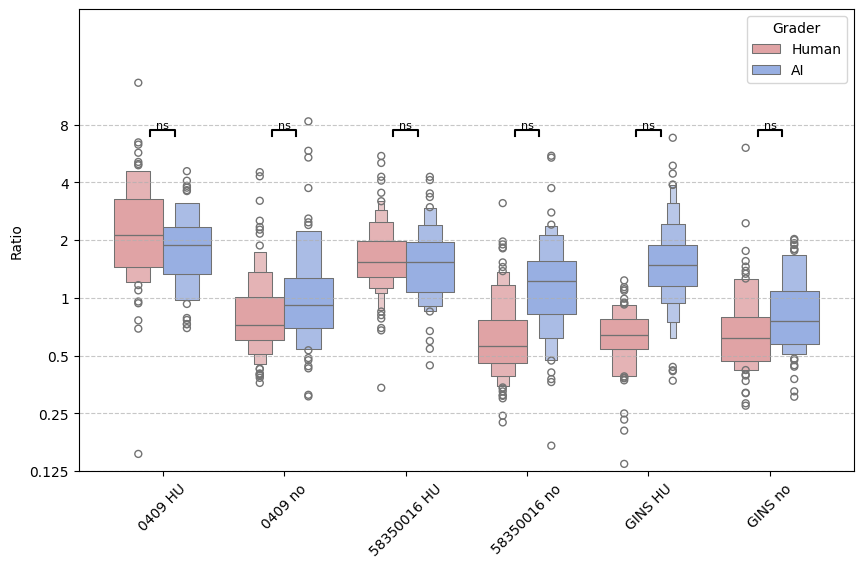

In [32]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp7/").iterdir():    
    df  = load_experiment_predictions(dir)

    df["Type"] = dir.stem.replace("_", " ").replace("20170919 ", "")  # Extract the type from the directory name
    df["Ratio"] = df["Ratio"]  # Invert the ratio to match the human grading

    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']

gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp7/20170918_GINSforkprog.xlsx", header=[2, 3], sheet_name="ratios")
# Get the first level of the multi-index columns
conditions = np.unique([col[0] for col in gt.columns[1:]])

gts = []
for condition in conditions:
    gt1 = pd.DataFrame({
        "Ratio": 1/gt[(condition, "red/green")],
        "Type": condition,
        "Grader": "Human"
    }) 
    gts.append(gt1)

df = pd.concat(gts + [df], ignore_index=True)
plt.figure(figsize=(10, 6))
create_boxen_plot(df, palette)
graders_statistical_test(df, 7)

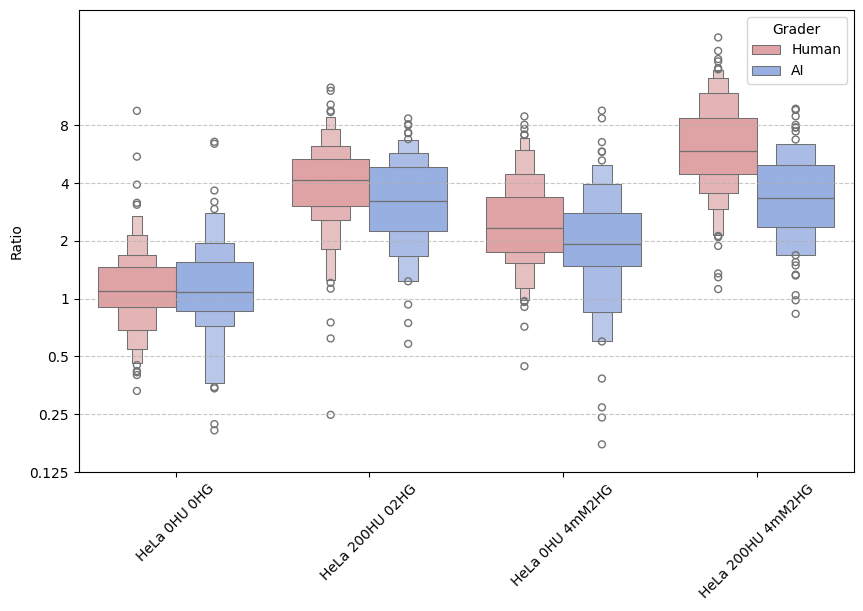

In [33]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp8/").iterdir():    
    df  = load_experiment_predictions(dir)

    df["Type"] = dir.stem.replace("_", " ").replace("20170919 ", "")  # Extract the type from the directory name
    df["Ratio"] = df["Ratio"]  # Invert the ratio to match the human grading

    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']

gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp8/20171025_2HGfibres.xlsx", header=[2, 3], sheet_name="ratios")
# Get the first level of the multi-index columns
conditions = np.unique([col[0] for col in gt.columns[1:]])

gts = []
for condition in conditions:
    gt1 = pd.DataFrame({
        "Ratio": 1/gt[(condition, "ratio")],
        "Type": condition,
        "Grader": "Human"
    }) 
    gts.append(gt1)

df = pd.concat(gts + [df], ignore_index=True)

df.replace({"Type": {"0 mM 2HG 0 µM HU": "HeLa 0HU 0HG",
                     "0 mM 2HG 200 µM HU": "HeLa 200HU 02HG",
                     "4 mM 2HG 0 µM HU": "HeLa 0HU 4mM2HG",
                     "4 mM 2HG 200 µM HU": "HeLa 200HU 4mM2HG"}}, inplace=True)
plt.figure(figsize=(10, 6))
create_boxen_plot(df, palette)

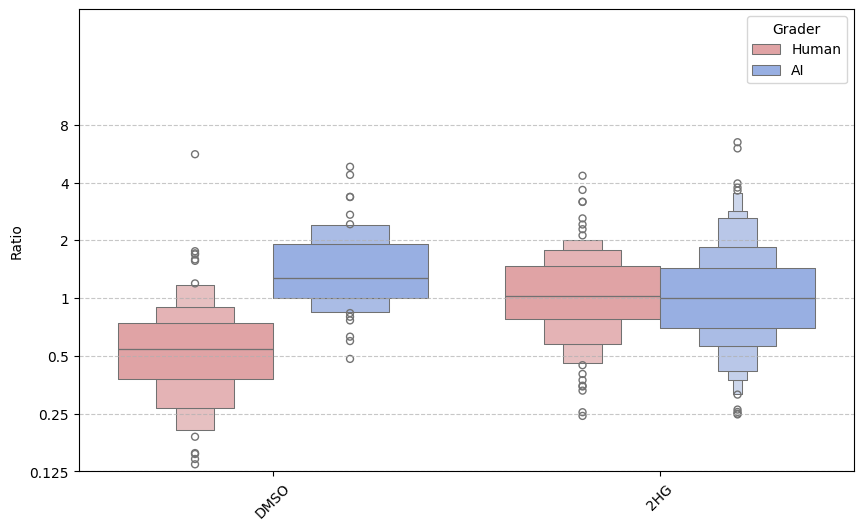

In [34]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp9/").iterdir():    
    df  = load_experiment_predictions(dir)

    df["Type"] = dir.stem.replace("_", " ").replace("20170919 ", "")  # Extract the type from the directory name
    df["Ratio"] = df["Ratio"]  # Invert the ratio to match the human grading

    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']

gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp9/20171102_2HGDMSO_fibres.xlsx", header=[1], sheet_name="Sheet4")
conditions = ["DMSO", "2HG"]

gts = []
for condition, ratio_col in zip(conditions, ["Unnamed: 3", "Unnamed: 7"]):
    gt1 = pd.DataFrame({
        "Ratio": 1/gt[ratio_col],
        "Type": condition,
        "Grader": "Human"
    }) 
    gts.append(gt1)

df = pd.concat(gts + [df], ignore_index=True)

df.replace({"Type": {"DMSO1": "DMSO",
                     "2HG1": "2HG",
                     }}, inplace=True)
plt.figure(figsize=(10, 6))
create_boxen_plot(df, palette)

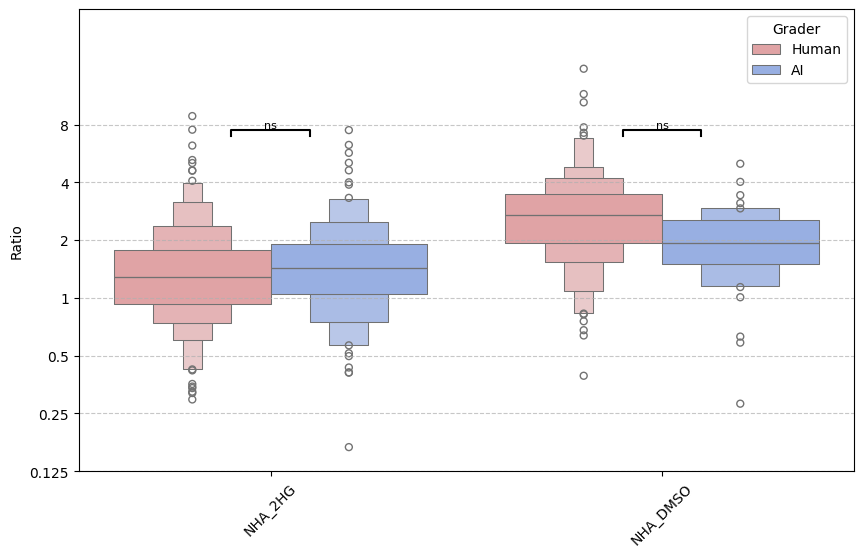

In [35]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp10/").iterdir():    
    df  = load_experiment_predictions(dir)

    df["Type"] = dir.stem.replace("_A", "")
    df["Ratio"] = df["Ratio"]  # Invert the ratio to match the human grading

    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']

gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp10/20171130_fibres.xlsx", header=[3, 4], sheet_name="Sheet2")
conditions = np.unique([col[0] for col in gt.columns[1:]])

gts = []
for condition in conditions:
    gt1 = pd.DataFrame({
        "Ratio": gt[(condition, "green/red")],
        "Type": condition,
        "Grader": "Human"
    }) 
    gts.append(gt1)

df = pd.concat(gts + [df], ignore_index=True)

df.replace({"Type": {"DMSO1": "DMSO",
                     "2HG1": "2HG",
                     }}, inplace=True)
plt.figure(figsize=(10, 6))
create_boxen_plot(df, palette)
graders_statistical_test(df, 7)

plt.savefig("Exp10_violin_plot.png", dpi=300, bbox_inches='tight')

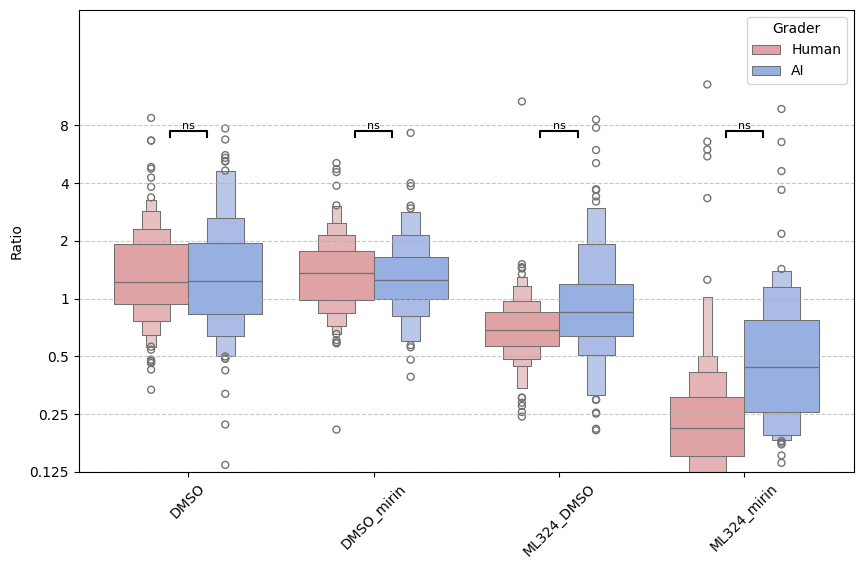

In [36]:
dfs = []
for dir in Path("/home/clement/Documents/data/DNAFiber/DNAI/Output/97Pierre/Exp11/").iterdir():    
    df  = load_experiment_predictions(dir)

    df["Type"] =  dir.stem.replace("HeLa_", "").replace("DMSO_1", "DMSO").replace("mirin", "DMSO_mirin")
    df["Ratio"] = df["Ratio"]  # Invert the ratio to match the human grading

    
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df = df[df['Fiber type'] == 'double']

gt = pd.read_excel("/home/clement/Documents/data/DNAFiber/Santiago/97Pierre/Exp11/20180124_MLmirin_FPassay.xlsx", header=[1, 2], sheet_name="tables")
conditions = np.unique([col[0] for col in gt.columns[1:]])

gts = []
for condition in conditions:
    gt1 = pd.DataFrame({
        "Ratio": gt[(condition, "green/red")],
        "Type": condition,
        "Grader": "Human"
    }) 
    gts.append(gt1)

df = pd.concat(gts + [df], ignore_index=True)

df.replace({"Type": {"ML324_DMSO_mirin": "ML324_mirin",
                     }}, inplace=True)
plt.figure(figsize=(10, 6))
create_boxen_plot(df, palette)
graders_statistical_test(df, 7)
plt.savefig("Exp11_violin_plot.png", dpi=300, bbox_inches='tight')

In [37]:
df

,Ratio,Type,Grader,Fiber ID,First analog (µm),Second analog (µm),Fiber type,Valid,image_name
0,2.075943,DMSO,Human,NaN,NaN,NaN,NaN,NaN,NaN
1,1.081934,DMSO,Human,NaN,NaN,NaN,NaN,NaN,NaN
2,1.102801,DMSO,Human,NaN,NaN,NaN,NaN,NaN,NaN
3,1.810775,DMSO,Human,NaN,NaN,NaN,NaN,NaN,NaN
4,2.113439,DMSO,Human,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1319,0.612903,ML324_DMSO,AI,3,8.397898,5.147099,double,True,HeLa_ML_DMSO_3_A_45_R3D
1320,1.124183,ML324_DMSO,AI,7,10.361922,11.648697,double,True,HeLa_ML_DMSO_3_A_45_R3D
1321,1.409091,ML324_DMSO,AI,0,10.429647,14.696321,double,True,HeLa_ML_DMSO_3_A_30_R3D
1322,1.000000,ML324_DMSO,AI,1,3.724874,3.724874,double,True,HeLa_ML_DMSO_3_A_19_R3D
